# Result parser

In [1]:
from collections import defaultdict

index_cols = defaultdict(int)
index_cols.update({
    "r-gitto-rank":1,
    'r-gitto-sirank':1,
    'somde':3,
    'spatialde':3,
})

p_use_columns = {
    "geary":"pval_norm_fdr_bh",
    "moran":"pval_norm_fdr_bh",
    "r-gitto-rank":"adj.p.value",
    "r-sparkx":"adjustedPval",
    'somde':'qval',
    'spatialde':'qval',
    'spanve-d':'fdrs',
    'spanve-k':'fdrs',
    'p.spanve-d':'fdrs',
    'p.spanve-k':'fdrs'
}
score_use_columns = {
    'r-gitto-sirank':'scores',
    'sepal':'average',

}

import os
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score as chscore
from sklearn.metrics import davies_bouldin_score as dbscore
from sklearn.metrics import silhouette_score as siscore



result_dir = "./recode/10XGenomics/"
data_ids = os.listdir(result_dir)

def parse_file(data_dir,soft):
    try:
        path = os.path.join(result_dir,data_dir,soft)
        file = [i for i in os.listdir(path) if i.endswith('csv')][0]
        file = os.path.join(path,file)
    except:
        print(data_dir,soft,'have no result file')
        return None
        
    if soft not in p_use_columns:
        use_col = score_use_columns[soft]
    else:
        use_col = p_use_columns[soft]
    
    df = pd.read_csv(file,index_col=index_cols[soft]).filter(like=use_col)
    df.columns = [soft]
    df = df.drop_duplicates()
    return df

def evaluate_genesets_ch(adata,genes):
    if len(genes)==0: return None,None
    ground = adata.obs['cluster'].dropna()
 
    temp_data = adata[ground.index,genes].X
    
    score1 = chscore(temp_data,ground.values)
    score2 = dbscore(temp_data,ground.values) #dfmoranI[genes].mean()
    
    return score1,score2

In [6]:
from tqdm import tqdm

df_metrics = pd.DataFrame(columns=['soft','data','n_sig','s1','s2'])

for data_id in tqdm(data_ids[:-1]):
    
    adata = sc.read_h5ad(f'./data/10XGenomics/{data_id}')

    sc.pp.normalize_total(
        adata,
        target_sum=1e6
    )
    sc.pp.log1p(adata)
    adata.X = (adata.X - adata.X.mean(0)) / (adata.X.std(0)+1e-7)

    softs = ['spanve-k','spanve-d','somde','moran','geary','r-sparkx','r-gitto-rank','sepal','r-gitto-sirank','spatialde','p.spanve-k','p.spanve-d']
    df_datares = pd.concat(
        [parse_file(data_id,soft) for soft in softs],
        axis=1
    )
    
    nmin = 100
    nmax = 1000
    nscore = int(0.1*df_datares.shape[0])
    
    for soft in df_datares.columns:
        if soft in p_use_columns:
            genes = df_datares.index[df_datares[soft]<0.05]
            if len(genes) > nmax:
                genes = df_datares[soft].sort_values().index[0:nmax]
            if len(genes) < nmin:
                genes = df_datares[soft].sort_values().index[0:nmin]
            s1,s2 = evaluate_genesets_ch(adata,genes)
            df_metrics.loc[len(df_metrics),:] = soft,data_id,genes.size,s1,s2
        elif soft in score_use_columns:
            genes = df_datares[soft].sort_values(ascending=False).index[0:nscore]
            s1,s2 = evaluate_genesets_ch(adata,genes)
            df_metrics.loc[len(df_metrics),:] = soft,data_id,genes.size,s1,s2
            
df_metrics['soft'] = df_metrics['soft'].map(
    {
        # 'spanve-k':'Spanve-k',
        # 'spanve-d':'Spanve-d',
        'p.spanve-k':'Spanve-k',
        'p.spanve-d':'Spanve-d',
        'somde':'SOMDE',
        'moran':'Moran test',
        'geary':'Geary test',
        'r-sparkx':'SPARK-X',
        'r-gitto-rank':'Gitto-Rank',
        'sepal':'sepal*',
        'r-gitto-sirank':'Gitto-siRank*',
        'spatialde':'SpatialDE'
    }
)

 29%|███████████████████████▋                                                           | 12/42 [00:51<02:13,  4.46s/it]/share/anaconda3/envs/SpaBench/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Targeted_Visium_Human_BreastCancer_Immunology1.2.0.h5ad r-gitto-sirank have no result file
Targeted_Visium_Human_BreastCancer_Immunology1.2.0.h5ad spatialde have no result file


 31%|█████████████████████████▋                                                         | 13/42 [00:51<01:34,  3.25s/it]/share/anaconda3/envs/SpaBench/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Targeted_Visium_Human_Cerebellum_Neuroscience2.0.0.h5ad r-gitto-sirank have no result file
Targeted_Visium_Human_Cerebellum_Neuroscience2.0.0.h5ad spatialde have no result file


 38%|███████████████████████████████▌                                                   | 16/42 [00:53<00:37,  1.44s/it]/share/anaconda3/envs/SpaBench/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Targeted_Visium_Human_OvarianCancer_Immunology1.2.0.h5ad r-gitto-sirank have no result file
Targeted_Visium_Human_OvarianCancer_Immunology1.2.0.h5ad spatialde have no result file


 40%|█████████████████████████████████▌                                                 | 17/42 [00:53<00:27,  1.11s/it]/share/anaconda3/envs/SpaBench/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Targeted_Visium_Human_OvarianCancer_Pan_Cancer1.2.0.h5ad r-gitto-sirank have no result file
Targeted_Visium_Human_OvarianCancer_Pan_Cancer1.2.0.h5ad spatialde have no result file


100%|███████████████████████████████████████████████████████████████████████████████████| 42/42 [02:18<00:00,  3.29s/it]


# Visuliz

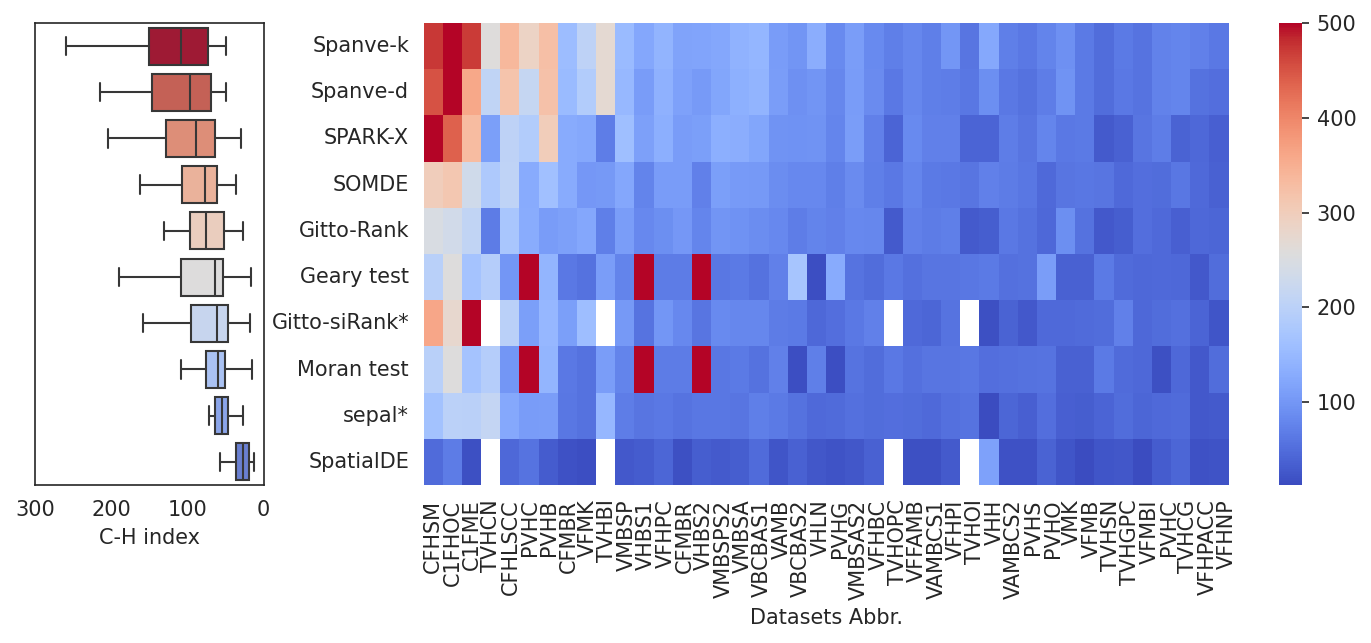

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style(style='white')

def data_id_trans(text):
    r = ''.join([i[0] for i in text.split('_')])
    return r

platte = 'coolwarm'
saturation=0.75
plot_metric = 's1'
df_vis = df_metrics.groupby(['data','soft']).apply(lambda x:x[plot_metric].values[0]).unstack().T

color_map = sns.color_palette(platte,as_cmap=True)
soft_order = df_vis.median(axis=1).sort_values(ascending=False).index
data_order = df_vis.median().sort_values(ascending=False).index
df_vis = df_vis.loc[soft_order,data_order]

fig = plt.figure(dpi=150,figsize=(12,4))
fig.subplots_adjust(wspace=0.7)
spec = fig.add_gridspec(1, 4)
ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1:])

sns.heatmap(
    df_vis,ax=ax1,
    cmap=color_map,
    vmax = 500
)
ax1.set_xticks(0.5+1.01*np.arange(len(data_order)))
_=ax1.set_xticklabels([data_id_trans(i) for i in data_order],rotation=90)
ax1.set_ylabel('')
ax1.set_xlabel('Datasets Abbr.')

sns.boxplot(
    y='soft',x=plot_metric,
    orient='h',
    data=df_metrics,
    order=soft_order,
    ax =ax0,
    linewidth=1,fliersize=0,
    saturation=0.75,
    palette={
        soft:sns.color_palette(platte,as_cmap=True)(1-i/len(soft_order),alpha=0.3)
        for i,soft in enumerate(soft_order)
    },
)
ax0.set_xlim(0,300)
ax0.invert_xaxis()
ax0.set_yticklabels([])
ax0.set_ylabel('')
ax0.set_xlabel('C-H index')

fig.savefig('./Results/10XGenomicx_CHIdx.pdf',bbox_inches='tight')

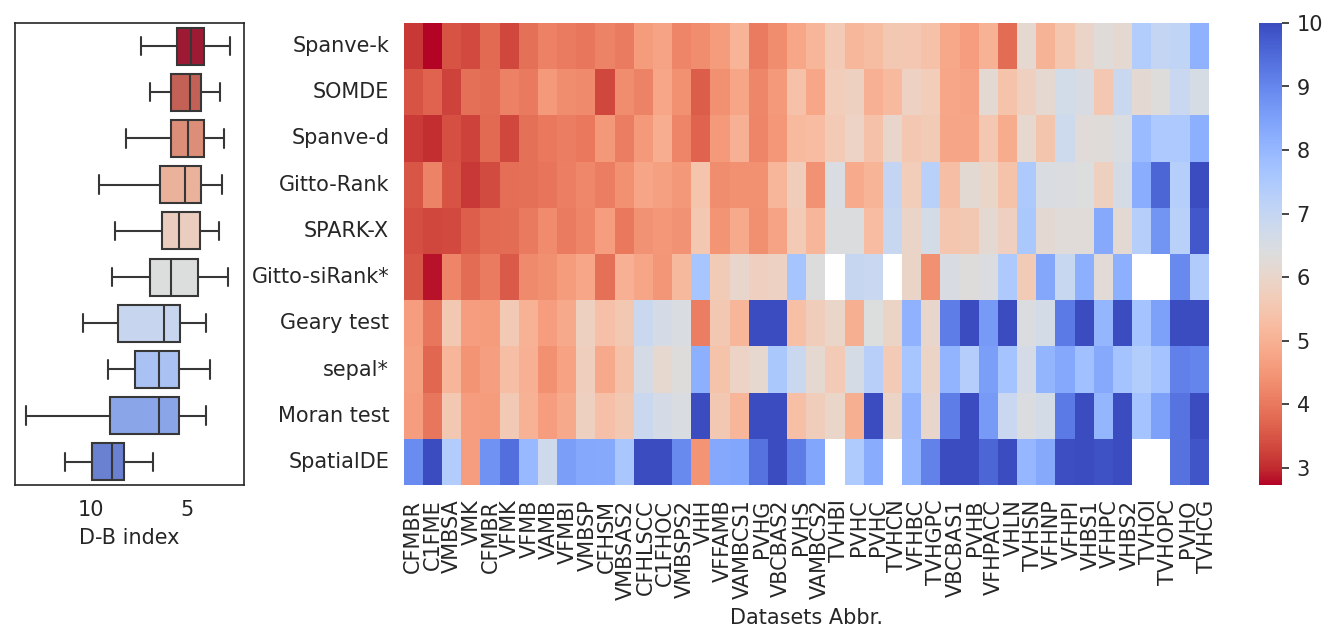

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style(style='white')

def data_id_trans(text):
    r = ''.join([i[0] for i in text.split('_')])
    return r
platte = 'coolwarm_r'

color_map = sns.color_palette(platte,as_cmap=True)
saturation=0.75
plot_metric = 's2'
df_vis = df_metrics.groupby(['data','soft']).apply(lambda x:x[plot_metric].values[0]).unstack().T

soft_order = df_vis.median(axis=1).sort_values().index
data_order = df_vis.median().sort_values().index
df_vis = df_vis.loc[soft_order,data_order]

fig = plt.figure(dpi=150,figsize=(12,4))
fig.subplots_adjust(wspace=0.7)
spec = fig.add_gridspec(1, 4)
ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1:])

sns.heatmap(
    df_vis,ax=ax1,
    cmap=color_map,vmax=10
)
ax1.set_xticks(0.5+1.01*np.arange(len(data_order)))
_=ax1.set_xticklabels([data_id_trans(i) for i in data_order],rotation=90)
ax1.set_ylabel('')
ax1.set_xlabel('Datasets Abbr.')

sns.boxplot(
    y='soft',x=plot_metric,
    orient='h',
    data=df_metrics,
    order=soft_order,
    ax =ax0,
    linewidth=1,fliersize=0,
    saturation=0.75,
    palette={
        soft:sns.color_palette(platte,as_cmap=True)(i/len(soft_order),alpha=0.3)
        for i,soft in enumerate(soft_order)
    },
)
ax0.set_yticklabels([])
ax0.set_xlim(2,14)
ax0.invert_xaxis()
ax0.set_ylabel('')
ax0.set_xlabel('D-B index')

fig.savefig('./Results/10XGenomicx_DBIdx.pdf',bbox_inches='tight')

/tmp/ipykernel_42331/2665836992.py:12: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axes[0].get_shared_x_axes().join(axes[0],axes[1])


(0.0, 10.0)

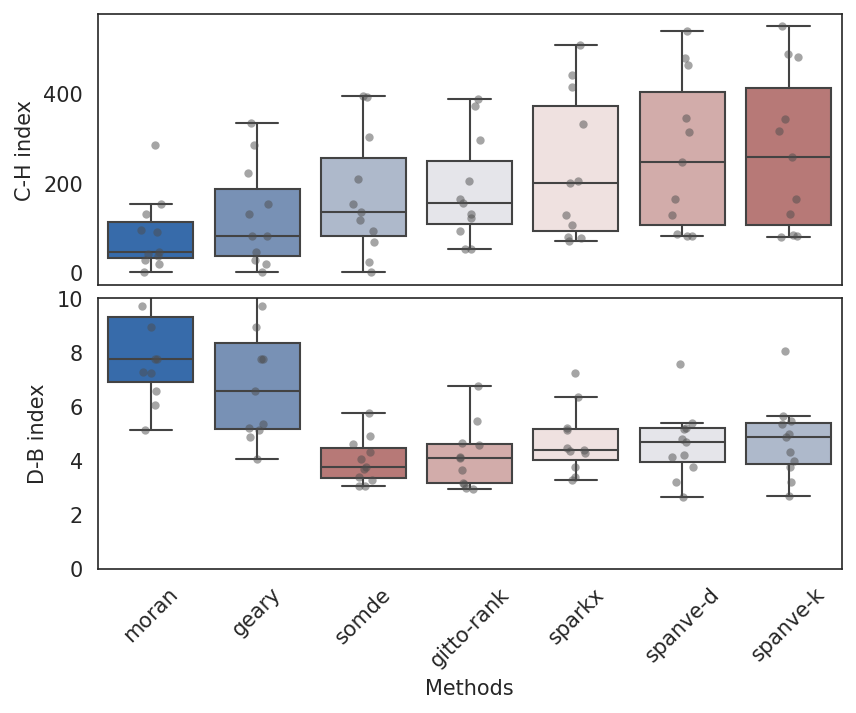

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

color_map = sns.color_palette('vlag',as_cmap=True)
saturation=0.75
order = df_metrics.groupby('soft')['s1'].median().sort_values().index

sns.set_style(style='white')
f,axes = plt.subplots(2,1,dpi=150)

f.subplots_adjust(hspace=0.05)
axes[0].get_shared_x_axes().join(axes[0],axes[1])

plot_metric = 's1'

sns.boxplot(
    x='soft',y=plot_metric,
    data=df_metrics,
    order=order,
    ax =axes[0],linewidth=1,fliersize=0,saturation=saturation,
    palette={
        soft:color_map(i/len(order))
        for i,soft in enumerate(df_metrics.groupby('soft')[plot_metric].median().sort_values().index)
    }
)
# Add in points to show each observation
sns.stripplot(x='soft',y=plot_metric,data=df_metrics,size=4, color=".3", linewidth=0,ax=axes[0],alpha=0.5,order=order)

axes[0].set_xticks([])
axes[0].set_xlabel('')
axes[0].set_ylabel('C-H index')
# axes[0].set_yticks([])

plot_metric = 's2'
sns.boxplot(
    x='soft',y=plot_metric,
    data=df_metrics,
    order=order,
    ax =axes[1], linewidth=1,fliersize=0,saturation=saturation,
    palette= {
        soft:color_map(i/len(order))
        for i,soft in enumerate(df_metrics.groupby('soft')[plot_metric].median().sort_values(ascending=False).index)
    }
)
_ = axes[1].set_xticklabels([i.replace('r-','') for i in order], rotation=45) 
axes[1].set_xlabel('Methods')
axes[1].set_ylabel('D-B index')
# axes[1].invert_yaxis()
sns.stripplot(x='soft',y=plot_metric,data=df_metrics,size=4, color=".3", linewidth=0,ax=axes[1],alpha=0.5,order=order)

axes[1].set_ylim(0,10)

